In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SmartCorrelatedSelection
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import metrics

In [2]:
train = pd.read_csv("train_B.csv")
val = pd.read_csv("val_B.csv")
test = pd.read_csv("test_B.csv")

In [3]:
# Separar características y etiquetas para conjunto de entrenamiento
X_train = train.drop(columns=['category'])
y_train = train['category']

# Separar características y etiquetas para conjunto de entrenamiento
X_test = test.drop(columns=['category'])
y_test = test['category']

X_val = val.drop(columns=['category'])
y_val = val['category']

In [5]:
RF = RandomForestClassifier()

param_grid = {'n_estimators': [15], 'max_depth': [15]} 
grid = GridSearchCV(RF, param_grid, cv=5, scoring='accuracy', return_train_score=True, verbose=1)
grid.fit(X_train, y_train)

print('Best Cross Validation Score:', grid.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


KeyboardInterrupt: 

In [11]:
RF =  grid.best_estimator_

print('Train Score:', RF.score(X_train, y_train))

y_pred = RF.predict(X_test)

start2=time.time()
print('Precision en test: ', accuracy_score(y_test, y_pred))
stop2=time.time()


tiempo2 = stop2 - start2
print(f"Tiempo de prediccion (Test) RF: {tiempo2}s")

Train Score: 0.8644677634345115
Precision en test:  0.8576643706950532
Tiempo de prediccion (Test) RF: 0.28311777114868164s


In [4]:
import joblib
RF = joblib.load('RF_model1.pkl')

y_pred = RF.predict(X_test)
print('Precision en test: ', accuracy_score(y_test, y_pred))

Precision en test:  0.8570037570444584


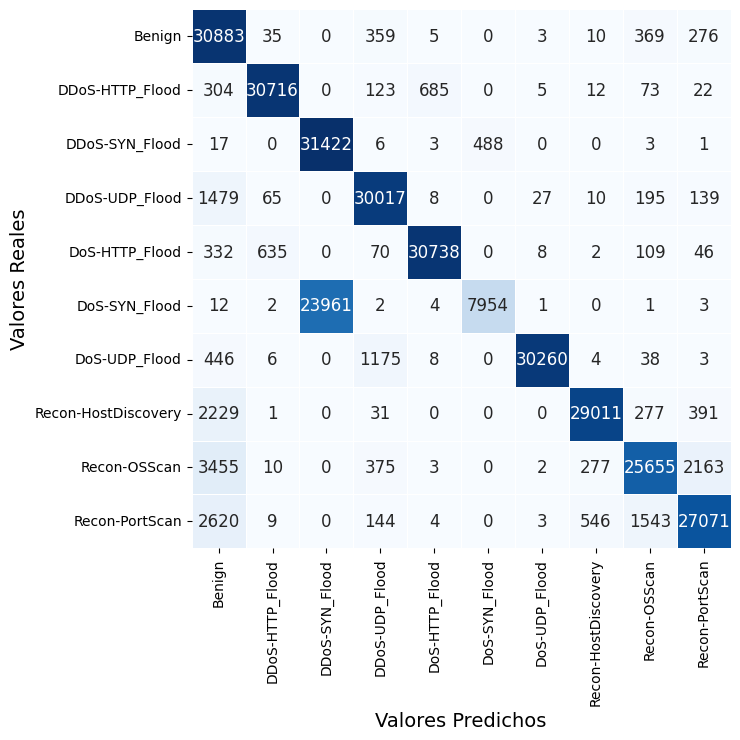

In [ ]:
cm = metrics.confusion_matrix(y_test, y_pred)
normalized_matrix = cm

class_names = ['Benign', 'DDoS-HTTP_Flood', 'DDoS-SYN_Flood', 'DDoS-UDP_Flood', 'DoS-HTTP_Flood', 'DoS-SYN_Flood', 'DoS-UDP_Flood', 'Recon-HostDiscovery', 'Recon-OSScan', 'Recon-PortScan']

# Plot
sns.heatmap(
    normalized_matrix, 
    annot=True, 
    fmt='0.0f', 
    linewidth=0.5,
    annot_kws={"size": 12}, 
    xticklabels=class_names,
    yticklabels=class_names, 
    square=True, 
    cmap='Blues', 
    cbar=False
)

fig = plt.gcf()
fig.set_size_inches(7, 7)
plt.ylabel('Valores Reales', fontsize=14)
plt.xlabel('Valores Predichos', fontsize=14)

# Guardar como PDF (¡hazlo antes del plt.show!)
plt.savefig('CM_RF_33car_10Class.pdf', format='pdf', bbox_inches='tight')

plt.show()


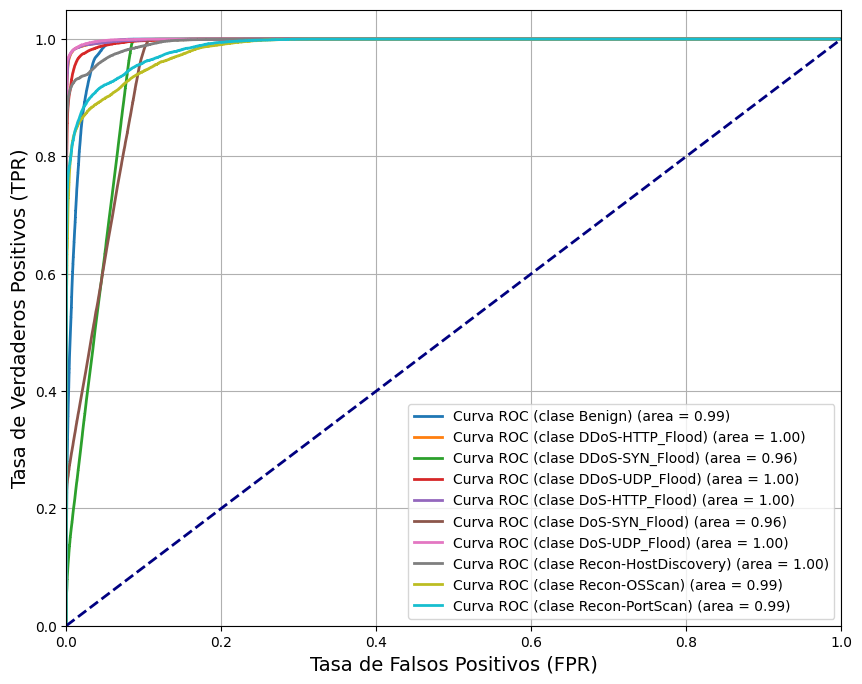

In [5]:
from sklearn.metrics import roc_curve, auc

y_pred_prob = RF.predict_proba(X_test)

# Binarizar las etiquetas
from sklearn.preprocessing import label_binarize
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i, class_label in enumerate(classes):
    fpr[class_label], tpr[class_label], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[class_label] = auc(fpr[class_label], tpr[class_label])

plt.figure(figsize=(10, 8))
for class_label in classes:
    plt.plot(fpr[class_label], tpr[class_label], lw=2,
             label=f'Curva ROC (clase {class_label}) (area = {roc_auc[class_label]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)', fontsize=14)
plt.ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('ROC_RF_33car_10Class.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [8]:
y_pred_prob = RF.predict_proba(X_test)

genuinos = []
impostores = []

for i in range(len(y_test)):

    etiqueta_real = y_test[i]
    indice_genuino = np.where(RF.classes_ == etiqueta_real)[0][0]
    score_genuino = y_pred_prob[i][indice_genuino]
    scores_impostores = np.delete(y_pred_prob[i], indice_genuino)
    genuinos.append(score_genuino)
    impostores.extend(scores_impostores)

genuinos = np.array(genuinos)
impostores = np.array(impostores)

print("Genuinos:", genuinos.shape)
print("Impostores:", impostores.shape)

Genuinos: (319400,)
Impostores: (2874600,)


In [9]:
thresholds = np.arange(-0.001, 1.001, 0.001)
FAR = []
FRR = []
for threshold in thresholds:
    FAR.append(np.sum(impostores >= threshold) / len(impostores))
    FRR.append(np.sum(genuinos <= threshold) / len(genuinos))

# Imprimir FAR, FRR
print("FAR:", FAR)
print("FRR:", FRR)

FAR: [np.float64(1.0), np.float64(1.0), np.float64(0.2452316844082655), np.float64(0.22775794893202533), np.float64(0.21512349544284423), np.float64(0.20434669171362974), np.float64(0.1953976205385097), np.float64(0.1877019411396368), np.float64(0.18167431990537813), np.float64(0.17666179642385027), np.float64(0.17248069296597787), np.float64(0.16842969456620052), np.float64(0.16480832115772628), np.float64(0.1612610450149586), np.float64(0.15807555833855144), np.float64(0.15499930425102623), np.float64(0.151553607458429), np.float64(0.14817191957141862), np.float64(0.14528490920475892), np.float64(0.14276421067278927), np.float64(0.14021359493494748), np.float64(0.13769254852849092), np.float64(0.13540075140889168), np.float64(0.13313330550337438), np.float64(0.13114137619147012), np.float64(0.12919640993529535), np.float64(0.12751617616364017), np.float64(0.12590725666179642), np.float64(0.12432442774646907), np.float64(0.12279099700827942), np.float64(0.12128226535865859), np.float6

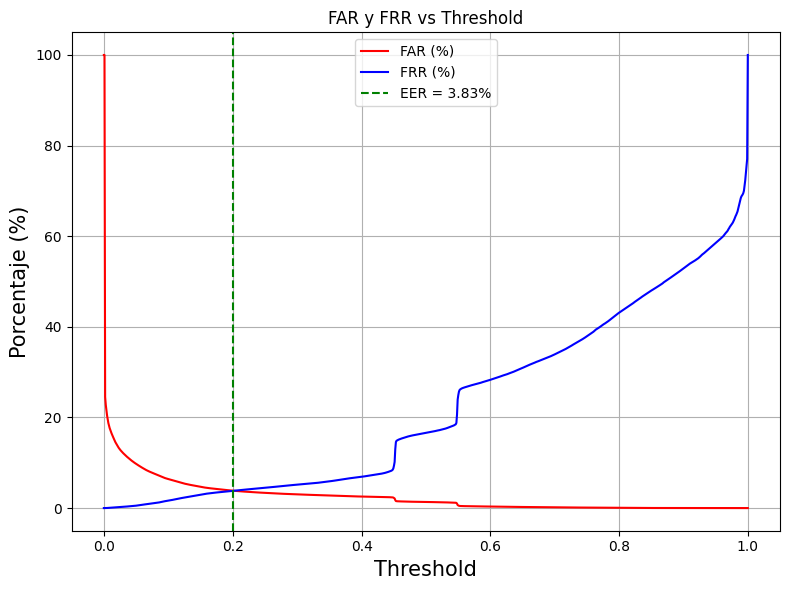

In [10]:
FAR_porcentaje = np.array(FAR) * 100
FRR_porcentaje = np.array(FRR) * 100

# Calcular EER
eer_threshold_index = np.nanargmin(np.abs(FAR_porcentaje - FRR_porcentaje))
eer_threshold = thresholds[eer_threshold_index]
eer = FAR_porcentaje[eer_threshold_index]

plt.figure(figsize=(8, 6))
plt.plot(thresholds, FAR_porcentaje, label='FAR (%)', color='red')
plt.plot(thresholds, FRR_porcentaje, label='FRR (%)', color='blue')
plt.axvline(eer_threshold, color='green', linestyle='--', label=f'EER = {eer:.2f}%')

plt.xlabel('Threshold', fontsize=15)
plt.ylabel('Porcentaje (%)', fontsize=15)
plt.title('FAR y FRR vs Threshold')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('FAR_FRR_RF_10CLASS.pdf', format='pdf', bbox_inches='tight')
plt.show()


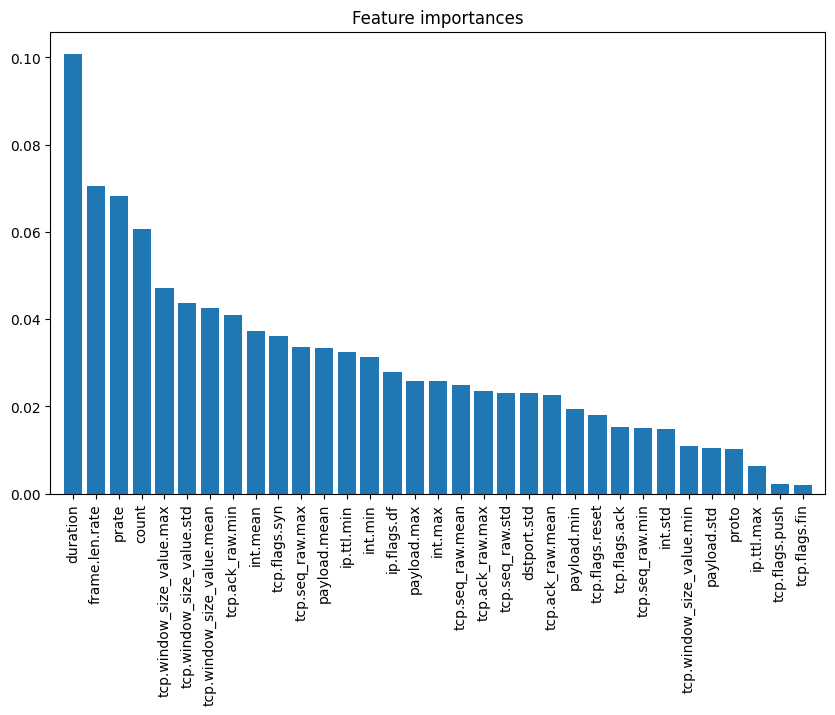

In [5]:
importances = RF.feature_importances_
#plotamos la importancia de las variables
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [6]:
X_train.columns[indices]

Index(['duration', 'frame.len.rate', 'prate', 'count',
       'tcp.window_size_value.max', 'tcp.window_size_value.std',
       'tcp.window_size_value.mean', 'tcp.ack_raw.min', 'int.mean',
       'tcp.flags.syn', 'tcp.seq_raw.max', 'payload.mean', 'ip.ttl.min',
       'int.min', 'ip.flags.df', 'payload.max', 'int.max', 'tcp.seq_raw.mean',
       'tcp.ack_raw.max', 'tcp.seq_raw.std', 'dstport.std', 'tcp.ack_raw.mean',
       'payload.min', 'tcp.flags.reset', 'tcp.flags.ack', 'tcp.seq_raw.min',
       'int.std', 'tcp.window_size_value.min', 'payload.std', 'proto',
       'ip.ttl.max', 'tcp.flags.push', 'tcp.flags.fin'],
      dtype='object')

In [12]:
RF = RandomForestClassifier(n_estimators=15, max_depth=15)

sel = SelectFromModel(RF, threshold=0.0285)
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(max_depth=15, n_estimators=15),
                threshold=0.0285)

In [5]:
# this command let's me visualise those features that were selected.

# sklearn will select those features which importance values
# are greater than the mean of all the coefficients.

sel.get_support()

array([False,  True, False, False, False, False, False, False, False,
        True, False,  True,  True,  True, False, False, False,  True,
       False,  True,  True, False,  True, False,  True,  True,  True,
        True, False,  True,  True, False, False])

In [13]:
# let's make a list and count the selected features

selected_feat = X_train.columns[(sel.get_support())]

len(selected_feat)

if "proto" not in selected_feat:
    selected_feat = selected_feat.append(pd.Index(["proto"]))
    
X_train = X_train[selected_feat]
X_val = X_val[selected_feat]
X_test = X_test[selected_feat]

In [14]:
RF = RandomForestClassifier()

param_grid = {'n_estimators': [15], 'max_depth': [15]} 
grid = GridSearchCV(RF, param_grid, cv=5, scoring='accuracy', return_train_score=True, verbose=1)
grid.fit(X_train, y_train)

print('Best Cross Validation Score:', grid.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Cross Validation Score: 0.8121378027070307


In [ ]:
RF =  grid.best_estimator_

print('Train Score:', RF.score(X_train, y_train))

y_pred = RF.predict(X_test)

start2=time.time()
print('Precision en test: ', accuracy_score(y_test, y_pred))
stop2=time.time()


tiempo2 = stop2 - start2
print(f"Tiempo de prediccion (Test) RF: {tiempo2}s")

Train Score: 0.8441802420761654
Precision en test:  0.8372667501565435
Tiempo de prediccion (Test) RF: 0.26689577102661133s


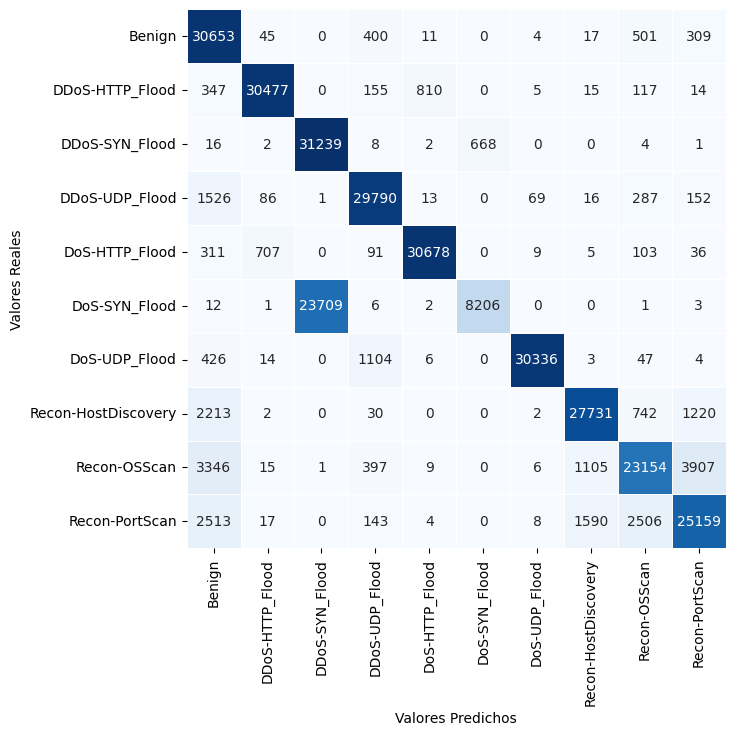

In [10]:
cm = metrics.confusion_matrix(y_test, y_pred)
normalized_matrix = cm #/ cm.sum(axis=1, keepdims=True)

class_names = ['Benign', 'DDoS-HTTP_Flood', 'DDoS-SYN_Flood', 'DDoS-UDP_Flood', 'DoS-HTTP_Flood', 'DoS-SYN_Flood', 'DoS-UDP_Flood', 'Recon-HostDiscovery', 'Recon-OSScan', 'Recon-PortScan']

sns.heatmap(normalized_matrix, annot = True, fmt = '0.0f', linewidth=0.5, xticklabels=class_names,
            yticklabels=class_names, square = True, cmap='Blues', cbar = False)

fig = plt.gcf()
fig.set_size_inches(7, 7)

plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

In [11]:
import joblib
joblib.dump(RF, 'RF_model2.pkl')

['RF_model2.pkl']

In [7]:
RF2 = joblib.load('RF_model2.pkl')
y_pred2 = RF2.predict(X_test)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- dstport.std
- int.max
- int.std
- ip.flags.df
- ip.ttl.max
- ...


In [32]:
X_train = pd.DataFrame(X_train, columns=selected_feat)
X_val = pd.DataFrame(X_val, columns=selected_feat)
X_test = pd.DataFrame(X_test, columns=selected_feat)

In [12]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
train = pd.concat([X_train, y_train], axis=1)

X_val_reducido = X_val.reset_index(drop=True)
y_val_reducido = y_val.reset_index(drop=True)
val = pd.concat([X_val_reducido, y_val_reducido], axis=1)

X_test_reducido = X_test.reset_index(drop=True)
y_test_reducido = y_test.reset_index(drop=True)
test = pd.concat([X_test_reducido, y_test_reducido], axis=1)


In [13]:
train.to_csv('train_QNN2.csv', index=False)
test.to_csv('test_QNN2.csv', index=False)
val.to_csv('val_QNN2.csv', index=False)